# Nivell 1

- Exercici 1

Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

In [2]:
delayed_flights = pd.read_csv('C:\\Users\\formacio\\Gabriel De Santis\\Datasets\\DelayedFlights.csv', sep=',')
delayed_flights

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,7009710,2008,12,13,6,1250.0,1220,1617.0,1552,DL,...,9.0,18.0,0,N,0,3.0,0.0,0.0,0.0,22.0
1936754,7009717,2008,12,13,6,657.0,600,904.0,749,DL,...,15.0,34.0,0,N,0,0.0,57.0,18.0,0.0,0.0
1936755,7009718,2008,12,13,6,1007.0,847,1149.0,1010,DL,...,8.0,32.0,0,N,0,1.0,0.0,19.0,0.0,79.0
1936756,7009726,2008,12,13,6,1251.0,1240,1446.0,1437,DL,...,13.0,13.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [3]:
delayed_flights.drop(columns='Unnamed: 0', inplace=True)

En exercicis anteriors vam observar que les variables tipus month, week, etc. corresponíen a criteris cíclics, que els valors de UniqueCarrier, FlightNum, etc. eres categoríes que podíem codificar com a valors nominals i que la resta de valors eren numèrics. Aplicarem, per tant, tres encodings diferents segons la variable al nostre pipeline.

In [29]:
cyclical = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']
nominal = ['UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest', 'CancellationCode']
numerical = ['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 
             'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay',
           'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

In [5]:
delayed_flights[cyclical]

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime
0,1,3,4,2003.0,1955,2211.0,2225
1,1,3,4,754.0,735,1002.0,1000
2,1,3,4,628.0,620,804.0,750
3,1,3,4,1829.0,1755,1959.0,1925
4,1,3,4,1940.0,1915,2121.0,2110
...,...,...,...,...,...,...,...
1936753,12,13,6,1250.0,1220,1617.0,1552
1936754,12,13,6,657.0,600,904.0,749
1936755,12,13,6,1007.0,847,1149.0,1010
1936756,12,13,6,1251.0,1240,1446.0,1437


In [6]:
delayed_flights[nominal]

,UniqueCarrier,FlightNum,TailNum,Origin,Dest,CancellationCode
0,WN,335,N712SW,IAD,TPA,N
1,WN,3231,N772SW,IAD,TPA,N
2,WN,448,N428WN,IND,BWI,N
3,WN,3920,N464WN,IND,BWI,N
4,WN,378,N726SW,IND,JAX,N
...,...,...,...,...,...,...
1936753,DL,1621,N938DL,MSP,ATL,N
1936754,DL,1631,N3743H,RIC,ATL,N
1936755,DL,1631,N909DA,ATL,IAH,N
1936756,DL,1639,N646DL,IAD,ATL,N


In [7]:
delayed_flights[numerical]

,ActualElapsedTime,CRSElapsedTime,AirTime,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,128.0,150.0,116.0,8.0,810,4.0,8.0,NaN,NaN,NaN,NaN,NaN
1,128.0,145.0,113.0,19.0,810,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2,96.0,90.0,76.0,8.0,515,3.0,17.0,NaN,NaN,NaN,NaN,NaN
3,90.0,90.0,77.0,34.0,515,3.0,10.0,2.0,0.0,0.0,0.0,32.0
4,101.0,115.0,87.0,25.0,688,4.0,10.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,147.0,152.0,120.0,30.0,906,9.0,18.0,3.0,0.0,0.0,0.0,22.0
1936754,127.0,109.0,78.0,57.0,481,15.0,34.0,0.0,57.0,18.0,0.0,0.0
1936755,162.0,143.0,122.0,80.0,689,8.0,32.0,1.0,0.0,19.0,0.0,79.0
1936756,115.0,117.0,89.0,11.0,533,13.0,13.0,NaN,NaN,NaN,NaN,NaN


In [8]:
delayed_flights.isna().sum() / len(delayed_flights) * 100

Year                  0.000000
Month                 0.000000
DayofMonth            0.000000
DayOfWeek             0.000000
DepTime               0.000000
CRSDepTime            0.000000
ArrTime               0.367108
CRSArrTime            0.000000
UniqueCarrier         0.000000
FlightNum             0.000000
TailNum               0.000258
ActualElapsedTime     0.433043
CRSElapsedTime        0.010223
AirTime               0.433043
ArrDelay              0.433043
DepDelay              0.000000
Origin                0.000000
Dest                  0.000000
Distance              0.000000
TaxiIn                0.367108
TaxiOut               0.023493
Cancelled             0.000000
CancellationCode      0.000000
Diverted              0.000000
CarrierDelay         35.588855
WeatherDelay         35.588855
NASDelay             35.588855
SecurityDelay        35.588855
LateAircraftDelay    35.588855
dtype: float64

Observem que els vols cancelats produeixen una gran quantitat de null values a diferents variables. Pensem que lo millor serà eliminar les files, ja que el nombre de vols cancelats és petit.

In [9]:
delayed_flights[delayed_flights.Cancelled == 1].isna().sum() / len(delayed_flights[delayed_flights.Cancelled == 1]) * 100

Year                   0.000000
Month                  0.000000
DayofMonth             0.000000
DayOfWeek              0.000000
DepTime                0.000000
CRSDepTime             0.000000
ArrTime              100.000000
CRSArrTime             0.000000
UniqueCarrier          0.000000
FlightNum              0.000000
TailNum                0.000000
ActualElapsedTime    100.000000
CRSElapsedTime         0.000000
AirTime              100.000000
ArrDelay             100.000000
DepDelay               0.000000
Origin                 0.000000
Dest                   0.000000
Distance               0.000000
TaxiIn               100.000000
TaxiOut               71.879937
Cancelled              0.000000
CancellationCode       0.000000
Diverted               0.000000
CarrierDelay         100.000000
WeatherDelay         100.000000
NASDelay             100.000000
SecurityDelay        100.000000
LateAircraftDelay    100.000000
dtype: float64

Sembla que els null values de les variables CarrierDelay, WeatherDelay, etc. están relacionats amb ArrDelay, és a dir, que quan el retràs no supera els 14 minuts, no es recullen valors. En aquest cas, creiem que serà convenient imputar-los per 0.

In [10]:
delayed_flights[delayed_flights.CarrierDelay.isna()].ArrDelay.max()

14.0

Sembla que els vols desviats també afecten als valors nuls d'altres variables. Així que els eliminarem de la mateixa forma que els cancelats.

In [11]:
delayed_flights[delayed_flights.Diverted == 1].isna().sum() / len(delayed_flights[delayed_flights.Diverted == 1]) * 100

Year                   0.000000
Month                  0.000000
DayofMonth             0.000000
DayOfWeek              0.000000
DepTime                0.000000
CRSDepTime             0.000000
ArrTime               83.531081
CRSArrTime             0.000000
UniqueCarrier          0.000000
FlightNum              0.000000
TailNum                0.025793
ActualElapsedTime    100.000000
CRSElapsedTime         2.553521
AirTime              100.000000
ArrDelay             100.000000
DepDelay               0.000000
Origin                 0.000000
Dest                   0.000000
Distance               0.000000
TaxiIn                83.531081
TaxiOut                0.000000
Cancelled              0.000000
CancellationCode       0.000000
Diverted               0.000000
CarrierDelay         100.000000
WeatherDelay         100.000000
NASDelay             100.000000
SecurityDelay        100.000000
LateAircraftDelay    100.000000
dtype: float64

hem decidit que imputarem els valors nuls de TailNum per la moda.

In [12]:
delayed_flights.TailNum.isna().sum() / len(delayed_flights) * 100

0.0002581633843773977

Funció per al preprocesament de les dades (neteja de null values y creació/transformació de variables)

In [13]:
def Preprocessing(X):

    #ELIMINAR VALORES NULOS
    X = X.drop(columns='Year') #Delete Year
    X = X.drop(index=X[X.Cancelled == 1].index.values) #Delete Null values debido a Cancelled
    X = X.drop(columns='Cancelled')
    X = X.reset_index(drop=True)
    X = X.drop(index=X[X.Diverted == 1].index.values) #Delete null values debido Diverted
    X = X.drop(columns='Diverted')
    X = X.reset_index(drop=True)
    X.TailNum = X.TailNum.fillna(X.TailNum.mode()[0])
    X[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']] = X[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].fillna(0)
    
    #TRANSFORMACION A VARIABLES CÍCLICAS
    X['mnth_sin'] = np.sin((X.Month -1)*(2.*np.pi/12))
    X['mnth_cos'] = np.cos((X.Month -1)*(2.*np.pi/12))
    X['day_M_sin'] = np.sin((X.DayofMonth -1)*(2.*np.pi/31))
    X['day_M_cos'] = np.cos((X.DayofMonth -1)*(2.*np.pi/31))
    X['day_W_sin'] = np.sin((X.DayOfWeek -1)*(2.*np.pi/7))
    X['day_W_cos'] = np.cos((X.DayOfWeek -1)*(2.*np.pi/7))
    X['DepTime_sin'] = np.sin((X.DepTime)*(2.*np.pi/2400))
    X['DepTime_cos'] = np.cos((X.DepTime)*(2.*np.pi/2400))
    X['CRSDepTime_sin'] = np.sin((X.CRSDepTime)*(2.*np.pi/2359))
    X['CRSDepTime_cos'] = np.cos((X.CRSDepTime)*(2.*np.pi/2359))
    X['ArrTime_sin'] = np.sin((X.ArrTime)*(2.*np.pi/2400))
    X['ArrTime_cos'] = np.cos((X.ArrTime)*(2.*np.pi/2400))
    X['CRSArrTime_sin'] = np.sin((X.CRSArrTime)*(2.*np.pi/2400))
    X['CRSArrTime_cos'] = np.cos((X.CRSArrTime)*(2.*np.pi/2400))    
    X.drop(columns=cyclical, inplace=True)
    
    return X

Crearem els estimators per introduir-los al nostre pipeline més endavant.

In [14]:
class NominalEncoding(TransformerMixin, BaseEstimator):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in nominal:
            mapping = X[column].value_counts() / len(X)
            X[column] = X[column].map(mapping)
        return X

In [16]:
class Num_encoding(TransformerMixin, BaseEstimator):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        #LOG
        X = pd.DataFrame(data=np.ma.log(X.values).filled(0), columns=numerical)
        
        #ESTANDARIZACION
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        return X

In [17]:
column_enc = ColumnTransformer(
                    [('nominal_encoding', NominalEncoding(), nominal), 
                    ('numerical_encoding', Num_encoding(), numerical)])

Preprocesament de les dades

In [19]:
delayed_flights = Preprocessing(delayed_flights)

In [23]:
delayed_flights

,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,...,day_W_sin,day_W_cos,DepTime_sin,DepTime_cos,CRSDepTime_sin,CRSDepTime_cos,ArrTime_sin,ArrTime_cos,CRSArrTime_sin,CRSArrTime_cos
0,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,...,0.433884,-0.900969,-0.862072,0.506786,-0.880090,0.474807,-0.474856,0.880063,-0.442289,0.896873
1,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,...,0.433884,-0.900969,0.919821,-0.392337,0.926094,-0.377294,0.495459,-0.868632,0.500000,-0.866025
2,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,...,0.433884,-0.900969,0.997314,-0.073238,0.996756,-0.080484,0.860742,-0.509041,0.923880,-0.382683
3,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,...,0.433884,-0.900969,-0.997119,0.075849,-0.999280,-0.037946,-0.914607,0.404344,-0.946930,0.321439
4,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,...,0.433884,-0.900969,-0.933580,0.358368,-0.925590,0.378527,-0.667183,0.744894,-0.688355,0.725374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928366,DL,1621,N938DL,147.0,152.0,120.0,25.0,30.0,MSP,ATL,...,-0.974928,-0.222521,-0.130526,-0.991445,-0.107662,-0.994188,-0.887413,-0.460974,-0.796530,-0.604599
1928367,DL,1631,N3743H,127.0,109.0,78.0,75.0,57.0,RIC,ATL,...,-0.974928,-0.222521,0.988886,-0.148672,0.999627,-0.027297,0.699663,-0.714473,0.924878,-0.380263
1928368,DL,1631,N909DA,162.0,143.0,122.0,99.0,80.0,ATL,IAH,...,-0.974928,-0.222521,0.484046,-0.875042,0.774303,-0.632816,0.133121,-0.991100,0.477159,-0.878817
1928369,DL,1639,N646DL,115.0,117.0,89.0,9.0,11.0,IAD,ATL,...,-0.974928,-0.222521,-0.133121,-0.991100,-0.160445,-0.987045,-0.600420,-0.799685,-0.581413,-0.813608


Definim el pipeline

In [48]:
pipe = Pipeline([('encoding', column_enc), ('model', RandomForestRegressor(n_jobs=-1))])

Definim els paràmetres pel GridSearch

In [67]:
param_grid = dict(
                model__n_estimators = [50,100,200],
                model__max_depth = [10, 20, 50],
                model__max_features = ['auto', 'sqrt']
    )

Treballarem amb un sample, ja que el data set és molt gran.

In [42]:
sample = delayed_flights.sample(frac=0.1)

Dividim entre target i features, i entre train i test.

In [43]:
y = sample.ArrDelay
X = sample.drop(columns='ArrDelay')


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.5,
                                        random_state = 0, shuffle = True)

In [31]:
numerical.remove('ArrDelay') #eliminem ArrDelay de la llista per al column transformer

In [69]:
search = HalvingGridSearchCV(pipe, param_grid, random_state=0, cv=3, verbose=1).fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 10713
max_resources_: 96418
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 10713
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 6
n_resources: 32139
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 2
n_resources: 96417
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('encoding',
                                               ColumnTransformer(transformers=[('nominal_encoding',
                                                                                NominalEncoding(),
                                                                                ['UniqueCarrier',
                                                                                 'FlightNum',
                                                                                 'TailNum',
                                                                                 'Origin',
                                                                                 'Dest',
                                                                                 'CancellationCode']),
                                                                               ('numerical_encoding',
                                               

In [72]:
search.best_score_

0.9924935028578409

In [71]:
search.best_estimator_

Pipeline(steps=[('encoding',
                 ColumnTransformer(transformers=[('nominal_encoding',
                                                  NominalEncoding(),
                                                  ['UniqueCarrier', 'FlightNum',
                                                   'TailNum', 'Origin', 'Dest',
                                                   'CancellationCode']),
                                                 ('numerical_encoding',
                                                  Num_encoding(),
                                                  ['ActualElapsedTime',
                                                   'CRSElapsedTime', 'AirTime',
                                                   'DepDelay', 'Distance',
                                                   'TaxiIn', 'TaxiOut',
                                                   'CarrierDelay',
                                                   'WeatherDelay', 'NASDelay',
               

In [74]:
search.score(X_test, y_test)

0.9950827259511195

In [78]:
mean_squared_error(y_test, search.predict(X_test))

16.05525676267126

El model és capaç d'explicar el 99,5% de la variabilitat dels retrasos dels vols amb un MSE de 16.06

---

- Exercici 2

Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules

In [232]:
text_raw = """She tried to fling herself below the wheels of the first carriage as it reached her; but the red bag which she tried to drop out of her hand delayed her, and she was too late; she missed the moment. She had to wait for the next carriage. A feeling such as she had known when about to take the first plunge in bathing came upon her, and she crossed herself. That familiar gesture brought back into her soul a whole series of girlish and childish memories, and suddenly the darkness that had covered everything for her was torn apart, and life rose up before her for an instant with all its bright past joys. But she did not take her eyes from the wheels of the second carriage. And exactly at the moment when the space between the wheels came opposite her, she dropped the red bag, and drawing her head back into her shoulders, fell on her hands under the carriage, and lightly, as though she would rise again at once, dropped on to her knees. And at the same instant she was terror-stricken at what she was doing. “Where am I? What am I doing? What for?” She tried to get up, to drop backwards; but something huge and merciless struck her on the head and rolled her on her back. “Lord, forgive me all!” she said, feeling it impossible to struggle. A peasant muttering something was working at the iron above her. And the light by which she had read the book filled with troubles, falsehoods, sorrow, and evil, flared up more brightly than ever before, lighted up for her all that had been in darkness, flickered, began to grow dim, and was quenched forever."""

In [233]:
text_raw

'She tried to fling herself below the wheels of the first carriage as it reached her; but the red bag which she tried to drop out of her hand delayed her, and she was too late; she missed the moment. She had to wait for the next carriage. A feeling such as she had known when about to take the first plunge in bathing came upon her, and she crossed herself. That familiar gesture brought back into her soul a whole series of girlish and childish memories, and suddenly the darkness that had covered everything for her was torn apart, and life rose up before her for an instant with all its bright past joys. But she did not take her eyes from the wheels of the second carriage. And exactly at the moment when the space between the wheels came opposite her, she dropped the red bag, and drawing her head back into her shoulders, fell on her hands under the carriage, and lightly, as though she would rise again at once, dropped on to her knees. And at the same instant she was terror-stricken at what 

In [241]:
tokenized_word=word_tokenize(text_raw)
print(tokenized_word)

['She', 'tried', 'to', 'fling', 'herself', 'below', 'the', 'wheels', 'of', 'the', 'first', 'carriage', 'as', 'it', 'reached', 'her', ';', 'but', 'the', 'red', 'bag', 'which', 'she', 'tried', 'to', 'drop', 'out', 'of', 'her', 'hand', 'delayed', 'her', ',', 'and', 'she', 'was', 'too', 'late', ';', 'she', 'missed', 'the', 'moment', '.', 'She', 'had', 'to', 'wait', 'for', 'the', 'next', 'carriage', '.', 'A', 'feeling', 'such', 'as', 'she', 'had', 'known', 'when', 'about', 'to', 'take', 'the', 'first', 'plunge', 'in', 'bathing', 'came', 'upon', 'her', ',', 'and', 'she', 'crossed', 'herself', '.', 'That', 'familiar', 'gesture', 'brought', 'back', 'into', 'her', 'soul', 'a', 'whole', 'series', 'of', 'girlish', 'and', 'childish', 'memories', ',', 'and', 'suddenly', 'the', 'darkness', 'that', 'had', 'covered', 'everything', 'for', 'her', 'was', 'torn', 'apart', ',', 'and', 'life', 'rose', 'up', 'before', 'her', 'for', 'an', 'instant', 'with', 'all', 'its', 'bright', 'past', 'joys', '.', 'But', 

In [248]:
fdist = FreqDist(tokenized_word)
print(fdist)

fdist.most_common(10)

<FreqDist with 161 samples and 332 outcomes>


[(',', 21),
 ('the', 19),
 ('her', 18),
 ('she', 12),
 ('and', 11),
 ('.', 11),
 ('to', 9),
 ('was', 6),
 ('had', 5),
 ('for', 5)]

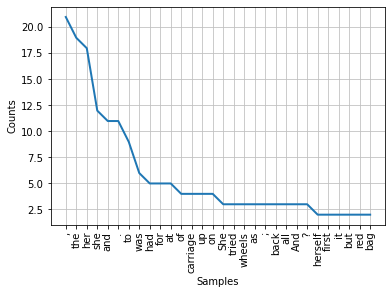

In [246]:
fdist.plot(30,cumulative=False)
plt.show()

# Nivell 2

- Exercici 1

Treu les stopwords i realitza stemming al teu conjunt de dades.

In [264]:
sentences=sent_tokenize(text_raw)
print(sentences)

['She tried to fling herself below the wheels of the first carriage as it reached her; but the red bag which she tried to drop out of her hand delayed her, and she was too late; she missed the moment.', 'She had to wait for the next carriage.', 'A feeling such as she had known when about to take the first plunge in bathing came upon her, and she crossed herself.', 'That familiar gesture brought back into her soul a whole series of girlish and childish memories, and suddenly the darkness that had covered everything for her was torn apart, and life rose up before her for an instant with all its bright past joys.', 'But she did not take her eyes from the wheels of the second carriage.', 'And exactly at the moment when the space between the wheels came opposite her, she dropped the red bag, and drawing her head back into her shoulders, fell on her hands under the carriage, and lightly, as though she would rise again at once, dropped on to her knees.', 'And at the same instant she was terro

In [270]:
stop_words=set(stopwords.words("english"))

filtered_sent=[]

for w in sentences:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",sentences)
print("Filterd Sentence:",filtered_sent)

Tokenized Sentence: ['She tried to fling herself below the wheels of the first carriage as it reached her; but the red bag which she tried to drop out of her hand delayed her, and she was too late; she missed the moment.', 'She had to wait for the next carriage.', 'A feeling such as she had known when about to take the first plunge in bathing came upon her, and she crossed herself.', 'That familiar gesture brought back into her soul a whole series of girlish and childish memories, and suddenly the darkness that had covered everything for her was torn apart, and life rose up before her for an instant with all its bright past joys.', 'But she did not take her eyes from the wheels of the second carriage.', 'And exactly at the moment when the space between the wheels came opposite her, she dropped the red bag, and drawing her head back into her shoulders, fell on her hands under the carriage, and lightly, as though she would rise again at once, dropped on to her knees.', 'And at the same i

In [275]:
for w in sentences:
    print(w)
    if w in stop_words:
        print('aqui')

She tried to fling herself below the wheels of the first carriage as it reached her; but the red bag which she tried to drop out of her hand delayed her, and she was too late; she missed the moment.
She had to wait for the next carriage.
A feeling such as she had known when about to take the first plunge in bathing came upon her, and she crossed herself.
That familiar gesture brought back into her soul a whole series of girlish and childish memories, and suddenly the darkness that had covered everything for her was torn apart, and life rose up before her for an instant with all its bright past joys.
But she did not take her eyes from the wheels of the second carriage.
And exactly at the moment when the space between the wheels came opposite her, she dropped the red bag, and drawing her head back into her shoulders, fell on her hands under the carriage, and lightly, as though she would rise again at once, dropped on to her knees.
And at the same instant she was terror-stricken at what s

In [269]:
filtered_sent

['She tried to fling herself below the wheels of the first carriage as it reached her; but the red bag which she tried to drop out of her hand delayed her, and she was too late; she missed the moment.',
 'She had to wait for the next carriage.',
 'A feeling such as she had known when about to take the first plunge in bathing came upon her, and she crossed herself.',
 'That familiar gesture brought back into her soul a whole series of girlish and childish memories, and suddenly the darkness that had covered everything for her was torn apart, and life rose up before her for an instant with all its bright past joys.',
 'But she did not take her eyes from the wheels of the second carriage.',
 'And exactly at the moment when the space between the wheels came opposite her, she dropped the red bag, and drawing her head back into her shoulders, fell on her hands under the carriage, and lightly, as though she would rise again at once, dropped on to her knees.',
 'And at the same instant she was

In [267]:
ps = PorterStemmer()

stemmed_sent=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))

print(stemmed_sent)

[]


In [262]:
len(stemmed_words)

177

# Nivell 3

- Exercici 1

Realitza sentiment analysis al teu conjunt de dades.

In [256]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(stemmed_words)

In [261]:
pd.DataFrame(data=text_counts.toarray(), columns=cv.get_feature_names())

,apart,backward,bag,bath,began,book,bright,brightli,brought,came,...,struck,struggl,suddenli,terror,torn,tri,troubl,wait,wheel,work
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


['apart',
 'backward',
 'bag',
 'bath',
 'began',
 'book',
 'bright',
 'brightli',
 'brought',
 'came',
 'carriag',
 'childish',
 'cover',
 'cross',
 'dark',
 'delay',
 'dim',
 'draw',
 'drop',
 'everyth',
 'evil',
 'exactli',
 'eye',
 'falsehood',
 'familiar',
 'feel',
 'fell',
 'flare',
 'flicker',
 'fling',
 'forev',
 'forgiv',
 'gestur',
 'girlish',
 'grow',
 'hand',
 'head',
 'huge',
 'imposs',
 'instant',
 'iron',
 'joy',
 'knee',
 'known',
 'late',
 'life',
 'light',
 'lightli',
 'lord',
 'memori',
 'merciless',
 'miss',
 'moment',
 'mutter',
 'opposit',
 'past',
 'peasant',
 'plung',
 'quench',
 'reach',
 'read',
 'red',
 'rise',
 'roll',
 'rose',
 'said',
 'second',
 'seri',
 'shoulder',
 'someth',
 'sorrow',
 'soul',
 'space',
 'stricken',
 'struck',
 'struggl',
 'suddenli',
 'terror',
 'torn',
 'tri',
 'troubl',
 'wait',
 'wheel',
 'work']